In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

from fem2D import Node, Element, plotMesh, readGmsh4, shapeFunctions, interp, readGLL, eraseCurrentMesh, plotNodesValues, plotMeshLimits,computeField

In [3]:
# chargement du maillage

eraseCurrentMesh()

file = "../meshes/square4.msh"

elements, nodes = readGmsh4(file, []) 
dof = len(nodes)
print(f"{dof=}")

Info    : Reading '../meshes/square4.msh'...
Info    : 9 entities
Info    : 6561 nodes
Info    : 480 elements
Info    : Done reading '../meshes/square4.msh'
dof=6561


In [4]:
# Chargement des points/poids d'intégration de GLL + dérivée des interpolateurs lagrangiens sur ces points

N = int(np.sqrt(len(elements[0].nodes))) - 1
xi,w,dh = readGLL(N)

print(f"{N=}")
print(f"{xi=}")

N=4
xi=array([-1.        , -0.65465367,  0.        ,  0.65465367,  1.        ])


In [5]:
# Pour chaque élément calcul:
# - du jacobien
# - de l'inverse de la matrice jacobienne
# La transformation depuis un élément quelconque vers l'élément de référence est l'interpolation bilinéaire

duphi = shapeFunctions["P1"]["duphi"]
dvphi = shapeFunctions["P1"]["dvphi"]

for e in elements:
    
    coords = e.getCoords()
    X, Y = coords[:,0], coords[:,1]
    
    Je11 = np.zeros((N+1,N+1))
    Je21 = np.zeros((N+1,N+1))
    Je12 = np.zeros((N+1,N+1))
    Je22 = np.zeros((N+1,N+1))
    
    e.detJ = np.zeros((N+1,N+1))
    
    e.iJe11 = np.zeros((N+1,N+1))
    e.iJe21 = np.zeros((N+1,N+1))
    e.iJe12 = np.zeros((N+1,N+1))
    e.iJe22 = np.zeros((N+1,N+1))

    dxdu = interp(duphi, X)
    dxdv = interp(dvphi, X)        
    dydu = interp(duphi, Y)
    dydv = interp(dvphi, Y)
    
    for i in range(N+1):
        for j in range(N+1):
            
            Je11[i,j] = dxdu(xi[i], xi[j])
            Je21[i,j] = dxdv(xi[i], xi[j])
            Je12[i,j] = dydu(xi[i], xi[j])
            Je22[i,j] = dydv(xi[i], xi[j])
            
            e.detJ[i,j] = Je11[i,j]*Je22[i,j] - Je21[i,j]*Je12[i,j]
            
            e.iJe11[i,j] =  Je22[i,j]/e.detJ[i,j]
            e.iJe22[i,j] =  Je11[i,j]/e.detJ[i,j]
            e.iJe21[i,j] = -Je21[i,j]/e.detJ[i,j]
            e.iJe12[i,j] = -Je12[i,j]/e.detJ[i,j]

In [6]:
# calcul des matrices élémentaires

delta  = np.eye(N+1)

for e in tqdm(elements):
    
    # KeTemp = np.zeros((N+1,N+1,N+1,N+1))
    e.Ke = np.zeros(((N+1)**2,(N+1)**2))
    
    for i in range(N+1):
        for j in range(N+1):
            for k in range(N+1):
                for l in range(N+1):
                    
                    a = i*(N+1) + j
                    b = k*(N+1) + l
                                        
                    for p in range(N+1):
                        for q in range(N+1):                 

                            e.Ke[a,b] += w[p]*w[q] * ((e.iJe11[p,q]*dh[i,p]*delta[j,q] + e.iJe12[p,q]*dh[j,q]*delta[i,p])*(e.iJe11[p,q]*dh[k,p]*delta[l,q] + e.iJe12[p,q]*dh[l,q]*delta[k,p]) + (e.iJe21[p,q]*dh[i,p]*delta[j,q] + e.iJe22[p,q]*dh[j,q]*delta[i,p])*(e.iJe21[p,q]*dh[k,p]*delta[l,q] + e.iJe22[p,q]*dh[l,q]*delta[k,p])) * e.detJ[p,q]


100%|██████████| 400/400 [00:38<00:00, 10.46it/s]


In [7]:
# calcul des matrices élémentaires

delta  = np.eye(N+1)

for e in tqdm(elements):
    
    # KeTemp = np.zeros((N+1,N+1,N+1,N+1))
    e.Me = np.zeros(((N+1)**2,(N+1)**2))
    
    for i in range(N+1):
        for j in range(N+1):

            a = i*(N+1) + j
            
            e.Me[a,a] = w[i]*w[j]*e.detJ[i,j]

100%|██████████| 400/400 [00:00<00:00, 21409.61it/s]


In [8]:
# assemblage

K = np.zeros((dof,dof))
M = np.zeros((dof,dof))
F = np.zeros(dof)

for e in tqdm(elements):
    for (i,n1) in enumerate(e.nodes):
        for (j,n2) in enumerate(e.nodes):
            K[n1.id,n2.id] += e.Ke[i,j]
            M[n1.id,n2.id] += e.Me[i,j]

100%|██████████| 400/400 [00:00<00:00, 731.03it/s]


In [9]:
# inverting mass matrix

iM = np.linalg.inv(M)

In [44]:
# résolution temporelle

Nit = 400
cfl = 0.25
Δx = 5.0/5
Δt = Δx* cfl
T = Δt*Nit 

time = np.linspace(0,T,Nit)

U = np.zeros((Nit, dof))
dU = np.zeros((Nit, dof))
ddU = np.zeros((Nit, dof))

# définition source

t0 = T/4.0         # tuning
f0 = 1/(4*Δx)     # tuning
f = lambda t : (4*(t-t0)**2*f0**4 - 2*f0**2)*np.exp(-(t-t0)**2*f0**2)
noeudSource = 450

In [45]:
# tests sur valeurs paramètres
print(f"CFL = {Δt/Δx}")
print(f"Δx = {Δx}m while λmin ~ {1/(4*f0)}")

CFL = 0.25
Δx = 1.0m while λmin ~ 1.0


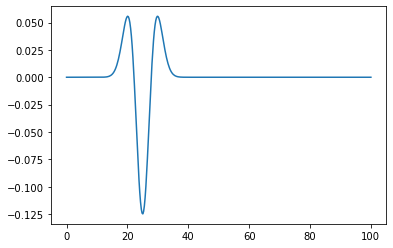

In [46]:
%matplotlib inline

plt.plot(time, f(time))

In [47]:
# FD
for i in tqdm(range(2,Nit)):
    F[noeudSource] = f(i*Δt)
    U[i,:] = 2*U[i-1,:] - U[i-2,:] + Δt**2*iM @ (F - K@U[i-1,:])

100%|██████████| 398/398 [00:42<00:00,  9.31it/s]


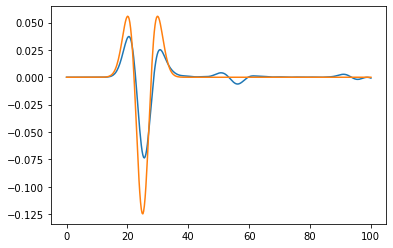

In [48]:
plt.plot(time, U[:,noeudSource])
plt.plot(time, f(time))

In [49]:
import matplotlib.animation as animation

# %matplotlib widget
%matplotlib tk

In [54]:
fig, ax = plt.subplots()
ax.set_aspect("equal", "box")

# plotMeshLimits(elements, ax)

umin = min(U.min(), -U.max())/2

dots = ax.scatter([n.x for n in nodes], [n.y for n in nodes], c=U[0,:], zorder=4, cmap="seismic", vmin=umin, vmax=-umin)
cbar = plt.colorbar(dots)
ttl = ax.annotate("it = 0", xy=(0.05, 0.05), xycoords='axes fraction', bbox=dict(facecolor='white', edgecolor='grey'), zorder=5)


def animate(i):
    dots.set_array(U[10*i,:])
    cbar.update_normal(dots)
    ttl.set_text(f"it = {10*i}")
    return dots,ttl,

ani = animation.FuncAnimation(fig, animate, interval=100, blit=True, frames = int(Nit/10))

ani.event_source.start()

plt.show()